In [16]:
## Setup

import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

## Step 1: RHF using cc-pvdz basis set


In [ ]:
"""
PySCF workflow for LiH:
- Build molecule
- Perform Hartree–Fock
- Define active space
- Run CASCI (Complete Active Space CI)
- Extract integrals (h1, h2)
- Compute Full CI reference energy
"""

import warnings

warnings.filterwarnings("ignore")

import pyscf     
import pyscf.cc
import pyscf.mcscf

# 1: Molecular properties for LiH
mol = pyscf.gto.Mole()   # Gaussian Type Orbital (GTO) basis

# Linear geometry of LiH in Angstrom (bond length ~1.595 Å)
mol.atom = [
    ["Li", (0.000000, 0.000000, 0.000000)],
    ["H",  (0.000000, 0.000000, 1.595000)],
]

mol.basis = "6-31G"   
mol.charge = 0           # neutral molecule
mol.spin = 0             # ground-state singlet (closed-shell)
mol.symmetry = "C2v"     # linear molecule; PySCF treats it as "C2v" internally if needed (it does not belong to this group)

mol.build()


# 2: Define active space - Lithium 1s is a deep core orbital, so we freeze it (1 frozen orbital)
n_frozen = 1
n_orb_total = mol.nao_nr()           # total number of atomic orbitals (basis functions)
active_space = range(n_frozen, n_orb_total)
num_orbitals = len(active_space)

# the active space is the set of orbitals that are not frozen and where correlation will matter

# 3: Hartree-Fock calculation (restricted as LiH is closed shell) + Get molecular integrals
scf = pyscf.scf.RHF(mol).run()  # single determinant

# Everything below is only for CASCI energy comparison

# Count number of electrons in active orbitals
n_electrons = int(sum(scf.mo_occ[active_space]))  # how many electrons are in the active space
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2

# mol.spin is the difference between the number of alpha and beta electrons (in other words the spin of the molecule)
# num_elec_a and num_elec_b are the number of alpha and beta electrons in the active space

cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))  # complete active space CI
mo = cas.sort_mo(active_space, base=0)  # molecular orbital coefficient matrix

# # 4: Extract one- and two-electron integrals 
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)  # one electron integrals (from scf)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)  # two electron integrals (from scf)

# # Compute exact energy (exact because CASCI is from diagonalising in the active space)
exact_energy = cas.run().e_tot

# # The CASCI is all for comparison as it is 'exact' (diagonalise H) but we don't use it in the workflow

converged SCF energy = -7.97926894842317
CASCI E = -7.99800203925752  E(CI) = -1.09475133293438  S^2 = 0.0000000


## Step 2: CCSD amplitudes

In [19]:
# Get CCSD t2 amplitudes for initializing the ansatz

ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run() # CCSD amplitudes from HF (scf)
t1 = ccsd.t1
t2 = ccsd.t2
# print(f't1: {t1}', f't2: {t2}')

# scf provides the one- and two-electron integrals and MO coefficients from the single-determinant HF solution

E(CCSD) = -7.998002217697514  E_corr = -0.01873326927433925


## Step 3: Prepare LUCJ ansatz using CCSD amplitudes

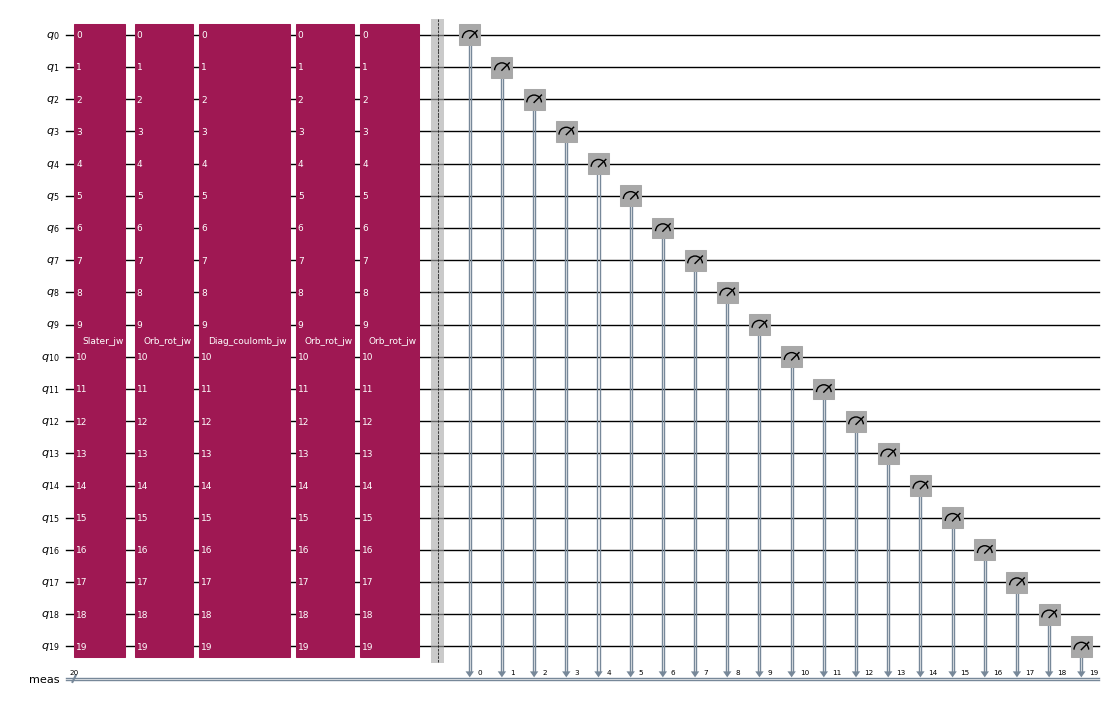

In [21]:

import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 1
# this is LUCJ - qubit layout like rungs
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)] # only nearest neighbours
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits) # transforms the uncorrelated HF reference into a correlated trial state
circuit.measure_all()
circuit.decompose().draw("mpl", scale=0.5, fold=-1)

## Step 4: Optimise for hardware

- Circuit current encodes the LUCJ ansatz for a linear “rung-ladder” connectivity
- Need to optimise for hardware
- Different LUCJ ansatz for "heavy-hex" topology

In [ ]:
token = 'YOUR API TOKEN HERE'
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_cloud", token=token, set_as_default=True, overwrite=True)

service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational = True, min_num_qubits = 100)

print(f"Using backend {backend.name}")

qiskit_runtime_service.__init__:WARNING:2025-11-17 16:04:39,872: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-17 16:04:40,277: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-17 16:04:43,079: Using instance: open-instance, plan: open


Using backend ibm_fez


## Optimising for Hardware:

Automatically finds the optimal qubit placement by searching all subgraphs of the hardware connectivity and scoring them for noise and connectivity — producing the best zig-zag layout for LUCJ/fermionic circuits.

In [ ]:
# Optimisation for hardware code

from typing import Sequence

import rustworkx
from qiskit.providers import BackendV2
from rustworkx import NoEdgeBetweenNodes, PyGraph

IBM_TWO_Q_GATES = {"cx", "ecr", "cz"}


def create_linear_chains(num_orbitals: int) -> PyGraph:
    """
    In zig-zag layout, there are two linear chains (with connecting qubits between
    the chains). This function creates those two linear chains: a rustworkx PyGraph
    with two disconnected linear chains. Each chain contains `num_orbitals` number
    of nodes, that is, in the final graph there are `2 * num_orbitals` number of nodes.

    Args:
        num_orbitals (int): Number orbitals or nodes in each linear chain. They are
            also known as alpha-alpha interaction qubits.

    Returns:
        A rustworkx.PyGraph with two disconnected linear chains each with `num_orbitals`
            number of nodes.
    """
    G = rustworkx.PyGraph()

    for n in range(num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    for n in range(num_orbitals, 2 * num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals, 2 * num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    return G


def create_lucj_zigzag_layout(
    num_orbitals: int, backend_coupling_graph: PyGraph
) -> tuple[PyGraph, int]:
    """
    This function creates the complete zigzag graph that 'can be mapped' to an IBM QPU with
    heavy-hex connectivity (the zigzag must be an isomorphic sub-graph to the QPU/backend
    coupling graph for it to be mapped).
    The zigzag pattern includes both linear chains (alpha-alpha interactions) and connecting
    qubits between the linear chains (alpha-beta interactions).

    Args:
        num_orbitals (int): Number of orbitals, that is, number of nodes in each alpha-alpha linear chain.
        backend_coupling_graph (PyGraph): The coupling graph of the backend on which the LUCJ ansatz
            will be mapped and run. This function takes the coupling graph as a undirected
            `rustworkx.PyGraph` where there is only one 'undirected' edge between two nodes,
            that is, qubits. Usually, the coupling graph of a IBM backend is directed (for example, Eagle devices
            such as ibm_brisbane) or may have two edges between two nodes (for example, Heron `ibm_torino`).
            A user needs to be make such graphs undirected and/or remove duplicate edges to make them
            compatible with this function.

    Returns:
        G_new (PyGraph): The graph with IBM backend compliant zigzag pattern.
        num_alpha_beta_qubits (int): Number of connecting qubits between the linear chains
            in the zigzag pattern. While we want as many connecting (alpha-beta) qubits between
            the linear (alpha-alpha) chains, we cannot accommodate all due to qubit and connectivity
            constraints of backends. This is the maximum number of connecting qubits the zigzag pattern
            can have while being backend compliant (that is, isomorphic to backend coupling graph).
    """
    isomorphic = False
    G = create_linear_chains(num_orbitals=num_orbitals)

    num_iters = num_orbitals
    while not isomorphic:
        G_new = G.copy()
        num_alpha_beta_qubits = 0
        for n in range(num_iters):
            if n % 4 == 0:
                new_node = 2 * num_orbitals + num_alpha_beta_qubits
                G_new.add_node(new_node)
                G_new.add_edge(n, new_node, None)
                G_new.add_edge(new_node, n + num_orbitals, None)
                num_alpha_beta_qubits = num_alpha_beta_qubits + 1
        isomorphic = rustworkx.is_subgraph_isomorphic(
            backend_coupling_graph, G_new
        )
        num_iters -= 1

    return G_new, num_alpha_beta_qubits


def lightweight_layout_error_scoring(
    backend: BackendV2,
    virtual_edges: Sequence[Sequence[int]],
    physical_layouts: Sequence[int],
    two_q_gate_name: str,
) -> list[list[list[int], float]]:
    """
    Lightweight and heuristic function to score isomorphic layouts. There can be many zigzag patterns,
    each with different set of physical qubits, that can be mapped to a backend. Some of them may
    include less noise qubits and couplings than others. This function computes a simple error score
    for each such layout. It sums up 2Q gate error for all couplings in the zigzag pattern (layout) and
    measurement of errors of physical qubits in the layout to compute the error score.

    Note:
        This lightweight scoring can be refined using concepts such as mapomatic.

    Args:
        backend (BackendV2): A backend.
        virtual_edges (Sequence[Sequence[int]]): Edges in the device compliant zigzag pattern where
            nodes are numbered from 0 to (2 * num_orbitals + num_alpha_beta_qubits).
        physical_layouts (Sequence[int]): All physical layouts of the zigzag pattern that are isomorphic
            to each other and to the larger backend coupling map.
        two_q_gate_name (str): The name of the two-qubit gate of the backend. The name is used for fetching
            two-qubit gate error from backend properties.

    Returns:
        scores (list): A list of lists where each sublist contains two items. First item is the layout, and
            second item is a float representing error score of the layout. The layouts in the `scores` are
            sorted in the ascending order of error score.
    """
    props = backend.properties()
    scores = []
    for layout in physical_layouts:
        total_2q_error = 0
        for edge in virtual_edges:
            physical_edge = (layout[edge[0]], layout[edge[1]])
            try:
                ge = props.gate_error(two_q_gate_name, physical_edge)
            except Exception:
                ge = props.gate_error(two_q_gate_name, physical_edge[::-1])
            total_2q_error += ge
        total_measurement_error = 0
        for qubit in layout:
            meas_error = props.readout_error(qubit)
            total_measurement_error += meas_error
        scores.append([layout, total_2q_error + total_measurement_error])

    return sorted(scores, key=lambda x: x[1])


def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()
    backend_coupling_graph = graph.to_undirected()

    edge_list = backend_coupling_graph.edge_list()
    removed_edge = []
    for edge in edge_list:
        if set(edge) in removed_edge:
            continue
        try:
            backend_coupling_graph.remove_edge(edge[0], edge[1])
            removed_edge.append(set(edge))
        except NoEdgeBetweenNodes:
            pass

    return backend_coupling_graph


def get_zigzag_physical_layout(
    num_orbitals: int, backend: BackendV2, score_layouts: bool = True
) -> tuple[list[int], int]:
    """The main function that generates the zigzag pattern with physical qubits that can be used
    as an `intial_layout` in a preset passmanager/transpiler.

    Args:
        num_orbitals (int): Number of orbitals.
        backend (BackendV2): A backend.
        score_layouts (bool): Optional. If `True`, it uses the `lightweight_layout_error_scoring`
            function to score the isomorphic layouts and returns the layout with less erroneous qubits.
            If `False`, returns the first isomorphic subgraph.

    Returns:
        A tuple of device compliant layout (list[int]) with zigzag pattern and an int representing
            number of alpha-beta-interactions.
    """
    backend_coupling_graph = _make_backend_cmap_pygraph(backend=backend)

    G, num_alpha_beta_qubits = create_lucj_zigzag_layout(
        num_orbitals=num_orbitals,
        backend_coupling_graph=backend_coupling_graph,
    )

    isomorphic_mappings = rustworkx.vf2_mapping(
        backend_coupling_graph, G, subgraph=True
    )
    isomorphic_mappings = list(isomorphic_mappings)

    edges = list(G.edge_list())

    layouts = []
    for mapping in isomorphic_mappings:
        initial_layout = [None] * (2 * num_orbitals + num_alpha_beta_qubits)
        for key, value in mapping.items():
            initial_layout[value] = key
        layouts.append(initial_layout)

    two_q_gate_name = IBM_TWO_Q_GATES.intersection(
        backend.configuration().basis_gates
    ).pop()

    if score_layouts:
        scores = lightweight_layout_error_scoring(
            backend=backend,
            virtual_edges=edges,
            physical_layouts=layouts,
            two_q_gate_name=two_q_gate_name,
        )

        return scores[0][0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

    return layouts[0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

In [24]:
initial_layout, _ = get_zigzag_physical_layout(num_orbitals, backend=backend)

from qiskit.transpiler import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# They both use pass manager which has the same initial layout

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict([('sx', 772), ('rz', 746), ('cz', 364), ('x', 87), ('measure', 20), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 426), ('rz', 413), ('cz', 172), ('x', 36), ('measure', 20), ('barrier', 1)])


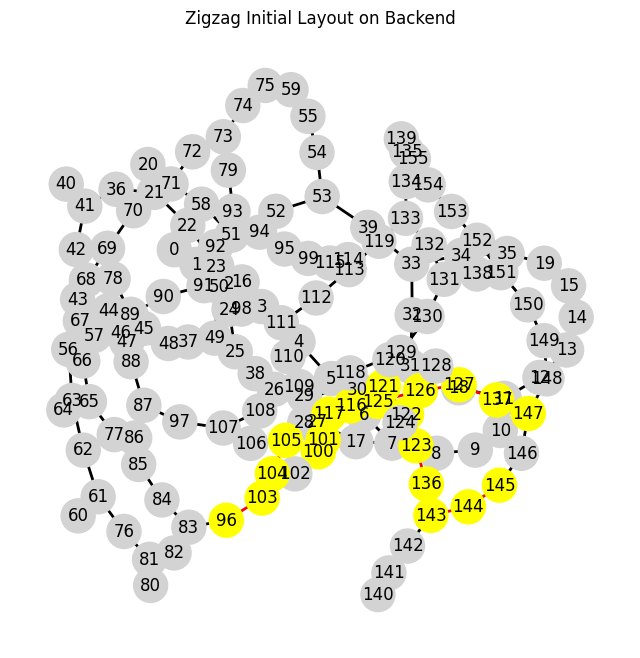

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.providers import BackendV2

def plot_initial_layout(backend: BackendV2, initial_layout: list[int]):
    # Get the backend coupling map as edges
    cmap = backend.coupling_map.graph.to_undirected()
    
    # Convert to networkx for plotting
    G = nx.Graph()
    for edge in cmap.edge_list():
        G.add_edge(edge[0], edge[1])
    
    # Highlight the nodes in the initial layout
    node_colors = []
    for n in G.nodes:
        if n in initial_layout:
            node_colors.append("yellow")  # part of layout
        else:
            node_colors.append("lightgrey")
    
    # Highlight edges in the zigzag network
    edge_colors = []
    for edge in G.edges:
        if edge[0] in initial_layout and edge[1] in initial_layout:
            if abs(initial_layout.index(edge[0]) - initial_layout.index(edge[1])) == 1:
                edge_colors.append("red")  # direct zigzag connection
                continue
        edge_colors.append("black")
    
    # Draw graph
    pos = nx.spring_layout(G)  # For now: force-directed layout
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
    nx.draw_networkx_labels(G, pos)
    plt.title("Zigzag Initial Layout on Backend")
    plt.axis("off")
    plt.show()

plot_initial_layout(backend=backend, initial_layout = initial_layout)

## Step 5: Execute on backend

In [ ]:
import matplotlib.pyplot as plt

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=5000)  ## Coded to avoid duplicates

In [30]:
session_id =job.session_id
id = job.job_id()
print(id)
print(job.status())

d4dkfaheg65s738liv00
DONE


1688


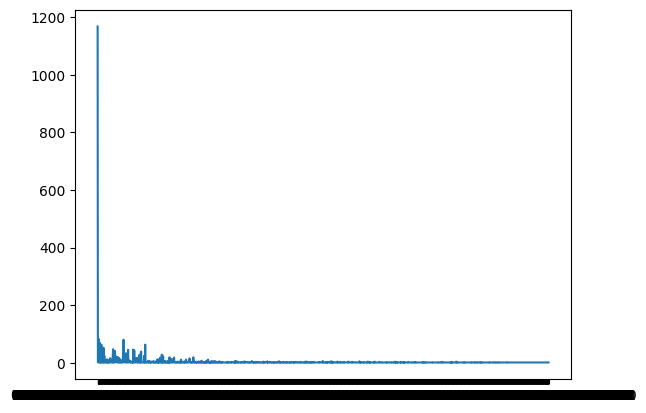

In [ ]:
primitive_result = job.result()
pub_result = primitive_result[0]

# Correct way to extract counts
counts = pub_result.data.meas.get_counts()

## Step 6: Estimate using SQD

In [32]:
from functools import partial

from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

Iteration 1
	Subsample 0
		Energy: -7.998002039257021
		Subspace dimension: 100
	Subsample 1
		Energy: -7.998002039257021
		Subspace dimension: 100
	Subsample 2
		Energy: -7.998002039257021
		Subspace dimension: 100
Iteration 2
	Subsample 0
		Energy: -7.998002039257021
		Subspace dimension: 100
	Subsample 1
		Energy: -7.998002039257021
		Subspace dimension: 100
	Subsample 2
		Energy: -7.998002039257021
		Subspace dimension: 100


## Step 7: Plot results

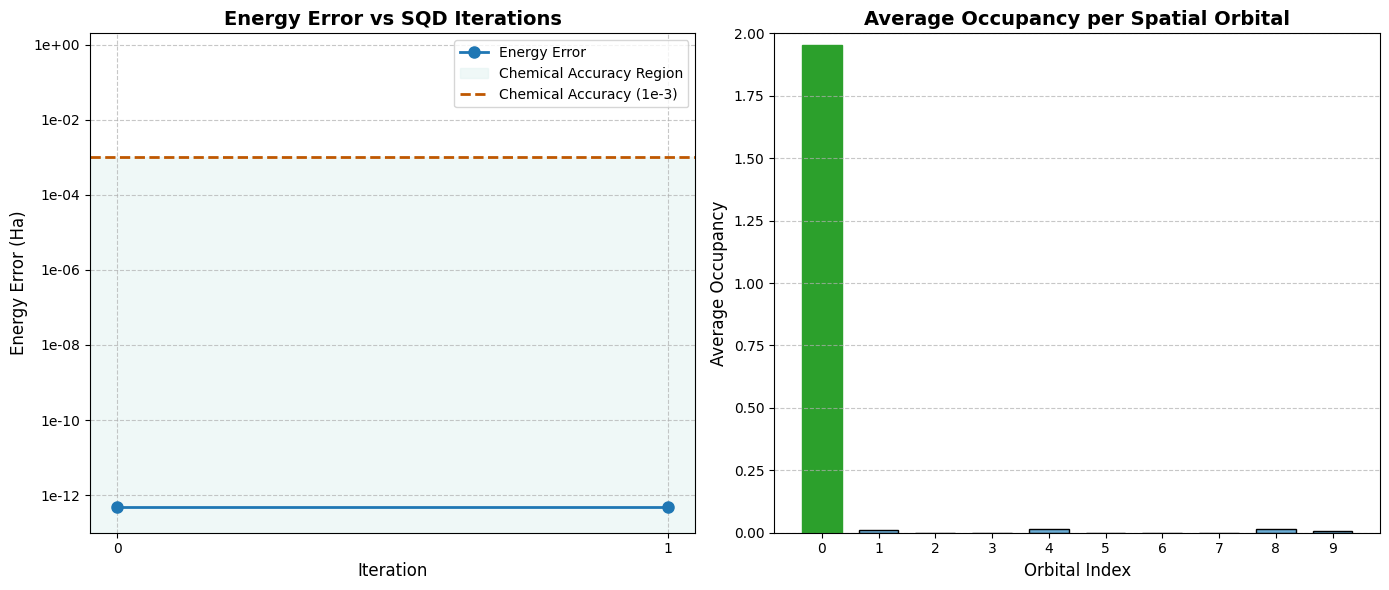

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]

# Y-axis ticks (extend to 1e-13)
yticks = [10**i for i in range(0, -14, -2)]  # 1e0 to 1e-13

# Chemical accuracy threshold (+/- 1 milli-Hartree)
chem_accuracy = 1e-3

# Data for avg orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

### Energy Error Plot ###
axs[0].plot(
    x1, e_diff, marker='o', linestyle='-', linewidth=2, markersize=8,
    label="Energy Error"
)
axs[0].set_yscale('log')
axs[0].set_ylim(1e-13, 2)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels([f"{y:.0e}" for y in yticks])
axs[0].set_xticks(x1)

# Highlighting the chemical accuracy threshold as a shaded region below 1e-3
axs[0].axhspan(1e-13, chem_accuracy, color="#E0F2F1", alpha=0.5, label="Chemical Accuracy Region")

# Plot the threshold line
axs[0].axhline(chem_accuracy, color="#BF5700", linestyle="--", linewidth=2, label="Chemical Accuracy (1e-3)")

axs[0].set_title("Energy Error vs SQD Iterations", fontsize=14, fontweight='bold')
axs[0].set_xlabel("Iteration", fontsize=12)
axs[0].set_ylabel("Energy Error (Ha)", fontsize=12)
axs[0].grid(which="both", linestyle="--", alpha=0.7)
axs[0].legend(fontsize=10)

### Average Orbital Occupancy Plot ###
bars = axs[1].bar(x2, y2, width=0.7, color="#6baed6", edgecolor="black")
axs[1].set_xticks(x2)
axs[1].set_ylim(0, 2)
axs[1].set_title("Average Occupancy per Spatial Orbital", fontsize=14, fontweight='bold')
axs[1].set_xlabel("Orbital Index", fontsize=12)
axs[1].set_ylabel("Average Occupancy", fontsize=12)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Highlight bars with occupancy > 1
for bar, occ in zip(bars, y2):
    if occ > 1.0:
        bar.set_color("#2ca02c")

plt.tight_layout()
plt.savefig(dpi=300, fname='FEZ_6-31G')
plt.show()